In [1]:
import os
import demoji
import fasttext
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.tokenize.casual import EMOTICON_RE
from matplotlib import pyplot as plt
from pandarallel import pandarallel

from reviews.preprocess import remove_urls, strip_html, remove_numbers
from reviews.config import processed_data_dir

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Data Cleaning

## Products

In [2]:
prod_df = pd.read_json(processed_data_dir / "meta.json.gz")
prod_df = prod_df.reindex(sorted(prod_df.columns), axis=1)  # sort columns
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32720 entries, 0 to 32719
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   asin         32720 non-null  object
 1   brand        32720 non-null  object
 2   category     32720 non-null  object
 3   description  32720 non-null  object
 4   price        32720 non-null  object
 5   title        32720 non-null  object
dtypes: object(6)
memory usage: 1.5+ MB


In [3]:
prod_df.head(10)

,asin,brand,category,description,price,title
0,7500653883,ECS Elitegroup,"[Electronics, Computers & Accessories, Compute...",[],,ECS PT800CE-A Socket 478 Motherboard Prescott ...
1,7799813393,MyGica,"[Electronics, Computers & Accessories, Compute...","[Mygica EZgrabber2 USB 2.0 Video Capture, VHS ...",,"Mygica EZgrabber USB 2.0 Video Capture, VHS to..."
2,B00000J3OG,Creative,"[Electronics, Computers & Accessories, Compute...",[],,Creative Labs DI5601 Modem Blaster 56K Interna...
3,B00000J3WY,APC,"[Electronics, Computers & Accessories, Compute...",[APC 650 VA Uninterruptable Power Supply],,APC 650VA Back-Up Power Supply (Discontinued b...
4,B00000J576,Creative,"[Electronics, Computers & Accessories, Compute...",[Unleash incredible graphics performance!],,Creative Labs 3DB6815BULK 3D Blaster Savage4 P...
5,B00000J579,Creative,"[Electronics, Computers & Accessories, Compute...",[Based on the award-winning Sound Blaster 16 t...,$2.05,Creative Labs Sound Blaster 16 PCI Sound Card
6,B00000J571,Creative,"[Electronics, Computers & Accessories, Compute...",[Unleash incredible graphics performance!],,Creative Labs 3DB6901 3D Blaster Savage4 AGP 32
7,B00000JBB8,Diamond,"[Electronics, Computers & Accessories, Compute...",[Monster Sound MX300 is the new-generation PCI...,,Diamond MX300 MonsterSound PCI Audio Accelerat...
8,B00000JBBJ,SONICblue,"[Electronics, Computers & Accessories, Compute...","[Based on the NVIDIA RIVA TNT Ultra chip set, ...",,Diamond Viper V770 Ultra Graphics Accelerator
9,B00000JBJ8,PNY,"[Electronics, Computers & Accessories, Compute...",[Adding memory to your new or existing desktop...,,PNY 64174ESEM4G-CS 128MB 168 Pin DIMM SDRAM PC...


### Transform Data

In [4]:
# keep the first subcategory
prod_df["category"] = prod_df["category"].parallel_apply(
    lambda x: x[4] if len(x) > 4 else "other"
)

# join description in a single string
prod_df["description"] = prod_df["description"].parallel_apply(lambda x: " ".join(x))

# remove html and replace empty with NA
for col in ["category", "description", "title", "brand", "asin"]:
    prod_df[col] = prod_df[col].astype("string").parallel_apply(strip_html)
    prod_df.loc[prod_df[col] == "", col] = np.nan

# fix price
prod_df["price"] = prod_df["price"].astype("string").parallel_apply(strip_html)
prod_df["price"] = prod_df["price"].str.replace("[\$,]", "", regex=True)
prod_df.loc[prod_df["price"].str.len() == 0, "price"] = np.nan
prod_df.loc[prod_df["price"].str.len() > 20, "price"] = np.nan

In [5]:
prod_df.head(10)

,asin,brand,category,description,price,title
0,7500653883,ECS Elitegroup,Motherboards,NaN,NaN,ECS PT800CE-A Socket 478 Motherboard Prescott ...
1,7799813393,MyGica,Internal TV Tuner & Capture Cards,"Mygica EZgrabber2 USB 2.0 Video Capture, VHS t...",NaN,"Mygica EZgrabber USB 2.0 Video Capture, VHS to..."
2,B00000J3OG,Creative,Internal Modems,NaN,NaN,Creative Labs DI5601 Modem Blaster 56K Interna...
3,B00000J3WY,APC,Internal Power Supplies,APC 650 VA Uninterruptable Power Supply,NaN,APC 650VA Back-Up Power Supply (Discontinued b...
4,B00000J576,Creative,Graphics Cards,Unleash incredible graphics performance!,NaN,Creative Labs 3DB6815BULK 3D Blaster Savage4 P...
5,B00000J579,Creative,Internal Sound Cards,Based on the award-winning Sound Blaster 16 te...,2.05,Creative Labs Sound Blaster 16 PCI Sound Card
6,B00000J571,Creative,Graphics Cards,Unleash incredible graphics performance!,NaN,Creative Labs 3DB6901 3D Blaster Savage4 AGP 32
7,B00000JBB8,Diamond,Graphics Cards,Monster Sound MX300 is the new-generation PCI ...,NaN,Diamond MX300 MonsterSound PCI Audio Accelerat...
8,B00000JBBJ,SONICblue,Graphics Cards,"Based on the NVIDIA RIVA TNT Ultra chip set, D...",NaN,Diamond Viper V770 Ultra Graphics Accelerator
9,B00000JBJ8,PNY,Memory,Adding memory to your new or existing desktop ...,NaN,PNY 64174ESEM4G-CS 128MB 168 Pin DIMM SDRAM PC...


### Convert Data Types

In [6]:
prod_df["asin"] = prod_df["asin"].astype("string")
prod_df["brand"] = prod_df["brand"].astype("category")
prod_df["category"] = prod_df["category"].astype("category")
prod_df["description"] = prod_df["description"].astype("string")
prod_df["price"] = prod_df["price"].astype("float")
prod_df["title"] = prod_df["title"].astype("string")

### Check missing or null values

In [7]:
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32720 entries, 0 to 32719
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   asin         32720 non-null  string  
 1   brand        32640 non-null  category
 2   category     32719 non-null  category
 3   description  30405 non-null  string  
 4   price        15855 non-null  float64 
 5   title        32720 non-null  string  
dtypes: category(2), float64(1), string(3)
memory usage: 1.2 MB


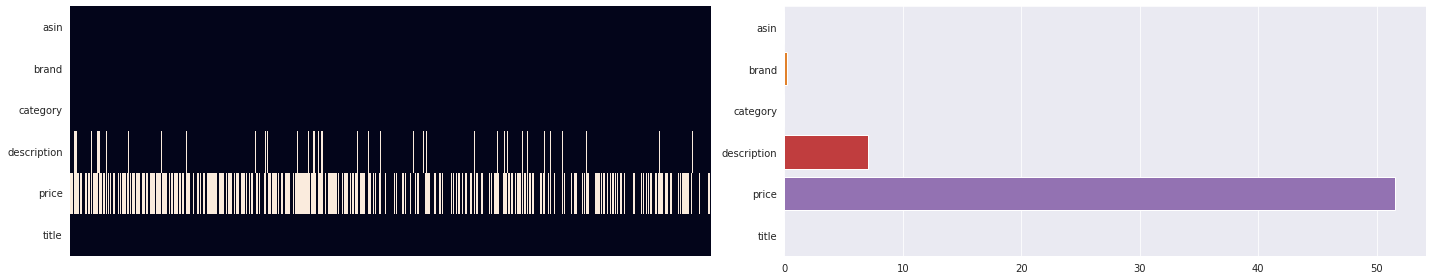

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.heatmap(prod_df.isna().T, cbar=False, xticklabels=False, ax=axes[0])
sns.barplot(
    y=prod_df.columns,
    x=(len(prod_df) - prod_df.count()) / len(prod_df) * 100,
    ax=axes[1],
)
fig.tight_layout()

### Duplicates

In [9]:
# remove duplicates
prod_df.drop_duplicates(inplace=True)

## Reviews

In [10]:
review_df = pd.read_json(processed_data_dir / "reviews.json.gz")
review_df = review_df.reindex(sorted(review_df.columns), axis=1)  # sort columns
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269027 entries, 0 to 269026
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   asin       269027 non-null  object        
 1   overall    269027 non-null  int64         
 2   summary    269027 non-null  object        
 3   text       269027 non-null  object        
 4   timestamp  269027 non-null  datetime64[ns]
 5   vote       269027 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 12.3+ MB


In [11]:
review_df.head(10)

,asin,overall,summary,text,timestamp,vote
0,7799813393,3,Good for what it can do.,Bought this to transfer video from some old eq...,2013-01-17,0
1,7799813393,4,works well,The EZGrabber2 works well but it's software is...,2012-09-04,0
2,7799813393,4,Cheap and it works,I got this because it was pretty decently pric...,2012-08-27,6
3,B00000J579,5,"Easy to Use, Almost everything you could want",This sound card doesn't reproduce MP3 or WAV f...,2000-10-10,32
4,B00000J579,3,Bathtub,"Essentially, this is the entry-level, 16-bit a...",2000-09-04,4
5,B00000J579,4,"Good low-end, no-hassle card",This is a basic sound card. Nothing fancy. T...,2002-07-03,6
6,B00000J579,3,Ok for the price and basic functions,This is a basic low-end sound card. It puts ou...,2002-04-04,8
7,B00000JDKU,4,good card,The Voodoo 3 is a great card that replaces bot...,1999-11-21,18
8,B00000JDKU,5,WOW!,This card is so fast and really high resolutio...,1999-07-15,4
9,B00000JF4L,5,An excellent card,Let me first state that I purchased this card ...,2000-03-15,38


In [12]:
# remove html and replace empty with NA
for col in ["asin", "overall", "summary", "text", "timestamp", "vote"]:
    review_df[col] = review_df[col].astype("string").parallel_apply(strip_html)
    review_df.loc[review_df[col] == "", col] = np.nan

### Convert Data Types

In [13]:
review_df["asin"] = review_df["asin"].astype("category")
review_df["overall"] = review_df["overall"].astype("category")
review_df["summary"] = review_df["summary"].astype("string")
review_df["text"] = review_df["text"].astype("string")
review_df["timestamp"] = pd.to_datetime(review_df["timestamp"], errors="coerce")
review_df["vote"] = review_df["vote"].astype("int")

In [14]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269027 entries, 0 to 269026
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   asin       269027 non-null  category      
 1   overall    269027 non-null  category      
 2   summary    269027 non-null  string        
 3   text       269025 non-null  string        
 4   timestamp  269027 non-null  datetime64[ns]
 5   vote       269027 non-null  int64         
dtypes: category(2), datetime64[ns](1), int64(1), string(2)
memory usage: 9.3 MB


### Missing Values

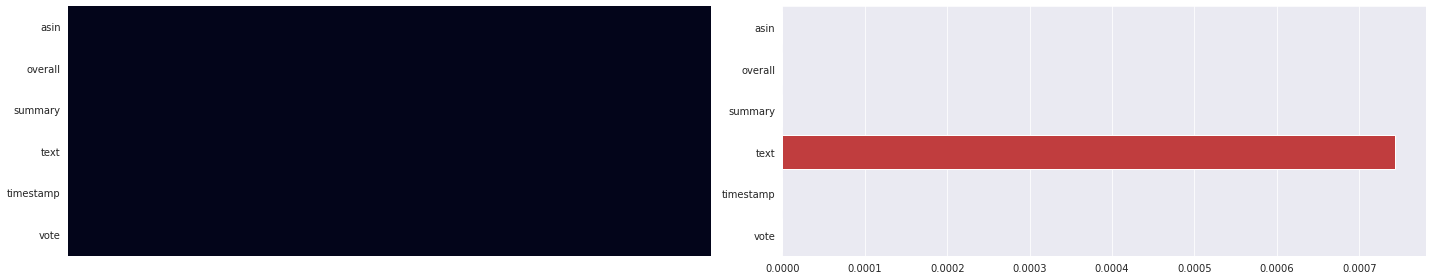

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.heatmap(review_df.isna().T, cbar=False, xticklabels=False, ax=axes[0])
sns.barplot(
    y=review_df.columns,
    x=(len(review_df) - review_df.count()) / len(review_df) * 100,
    ax=axes[1],
)
fig.tight_layout()

In [16]:
# remove empty text
review_df = review_df.loc[~review_df["text"].isna()]

### Emojis

In [17]:
def find_emoji(t):
    # return ", ".join(set(demoji.findall(t).keys()))
    return ", ".join(set(EMOTICON_RE.findall(t)))

review_df["emoji"] = review_df["text"].parallel_apply(find_emoji)

In [18]:
review_df["emoji"].value_counts()

               258118
:)               1870
d:               1146
p:                618
d;                539
                ...  
D-8, :), d=         1
D8, d;              1
:(, D:              1
>:|                 1
8P, =)              1
Name: emoji, Length: 794, dtype: int64

In [19]:
emoji_list = []
for emojis in set(review_df[review_df["emoji"] != ""]["emoji"].tolist()):
    emoji_list.extend(emojis.split(", "))

emoji_list = set(emoji_list)
print(emoji_list)

{'8p', ';-|', 'P-8', ';o)', ':o(', ';P', '8P', ":'(", '=D', ';)', ':{', '=(', ';(', 'Do;', ':(', ':\\', '=\\', 'd8', 'P:', ';-(', '(o;', ';-)', '=]', '8)', '=od', 'D:', '];', ':|', ':-)', "='D", '(*8', ';p', ':}', ';/', 'p:', '=p', ':-/', ':o)', ']:', '/O:', ':8', ';D', ':@', ':)', '8[', ':-|', '/=', '={', '8@', '(:', '8}', '>;-(', '/8', ':]', ';d', 'P;', ':-\\', ':d', 'D=', ');', '(8', '8:', '\\=', '>:/', ')-8', ':-D', ')=', ':/', '|:', ':-P', '>:(', ':P', '8-d', '<3', '=/', ']=', 'D-8', '[8', '):', "8'D", '(O8', '(=', '8-P', ':D', '{8', '8-p', ')8', '\\8', 'd;', ';]', 'P=', '=)', '8-D', 'D;', ':-]', ':=', '8D', 'p8', '=[', ":')", '@8', '8d', '@:', '{:', '(-:', '|=', ':op', 'p;', '8{', '(;', '=|', 'po8', 'p=', '>8)', '}=', ':-(', '[=', 'D8', '/:', "8')", ':p', 'do;', ';[', 'po=', 'd-8', '::', '8]', '8/', '};', '=-)', 'DO:', '8(', '/;', '=d', 'd:', ':O)', '=P', 'd=', 'do:', ':-p', ':[', '<:-)', '(O;', '8\\', 'p-8', '>:|', 'P8'}


### Duplicates

In [20]:
# remove duplicates
review_df.drop_duplicates(inplace=True)

### Language Detection

In [21]:
if not os.path.exists("/tmp/lid.176.bin"):
    !wget -O /tmp/lid.176.bin 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'

--2022-11-13 16:39:56--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘/tmp/lid.176.bin’

/tmp/lid.176.bin    100%[===================>] 125.18M  11.2MB/s    in 12s     

2022-11-13 16:40:09 (10.6 MB/s) - ‘/tmp/lid.176.bin’ saved [131266198/131266198]



In [22]:
model = fasttext.load_model("/tmp/lid.176.bin")

langs = []
for i, row in review_df.iterrows():
    text = row["summary"] + ". " + row["text"].replace("\n", " ")

    text = remove_urls(text)
    text = strip_html(text)
    text = remove_numbers(text)

    text = text.lower()

    lang = model.predict(text, threshold=0.9)

    if len(lang[0]) > 0:
        lang = lang[0][0].replace("__label__", "")

        if lang != "en":
            lang = "unknown"

        langs.append(lang)
    else:
        langs.append("unknown")

review_df["lang"] = langs

In [23]:
review_df["lang"].value_counts()

en         241438
unknown     27587
Name: lang, dtype: int64

In [24]:
# keep only english reviews
review_df = review_df.loc[review_df["lang"] == "en"]
review_df.drop(columns=["lang"], axis=1, inplace=True)

In [25]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241438 entries, 0 to 269026
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   asin       241438 non-null  category      
 1   overall    241438 non-null  category      
 2   summary    241438 non-null  string        
 3   text       241438 non-null  string        
 4   timestamp  241438 non-null  datetime64[ns]
 5   vote       241438 non-null  int64         
 6   emoji      241438 non-null  object        
dtypes: category(2), datetime64[ns](1), int64(1), object(1), string(2)
memory usage: 12.0+ MB


### Merge with Products

In [26]:
data_df = pd.merge(left=review_df, right=prod_df, on="asin", copy=False)

data_df["asin"] = data_df["asin"].astype("category")
data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")
data_df["overall"] = data_df["overall"].astype("category")

data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)
data_df.reset_index(drop=True, inplace=True)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152368 entries, 0 to 152367
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   asin         152368 non-null  category      
 1   overall      152368 non-null  category      
 2   summary      152368 non-null  string        
 3   text         152368 non-null  string        
 4   timestamp    152368 non-null  datetime64[ns]
 5   vote         152368 non-null  int64         
 6   emoji        152368 non-null  object        
 7   brand        152368 non-null  category      
 8   category     152368 non-null  category      
 9   description  152368 non-null  string        
 10  price        152368 non-null  float64       
 11  title        152368 non-null  string        
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), object(1), string(4)
memory usage: 10.6+ MB


In [27]:
data_df.to_json(processed_data_dir / "products_reviews.json.gz")